In [1]:
# standard libraries
import os
import csv
import random
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image

# scikit-learn libraries
from sklearn.metrics import (
    roc_curve, 
    auc,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

# pytorch libraries
import torch
from torch import cat
from torch import no_grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# qiskit libraries
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import StatevectorEstimator as Estimator

In [2]:
# Set parameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 5
NUM_OF_QUBITS = 2

In [3]:
class CustomDataset(Dataset):
    def __init__(self, base_path, image_size, mode):
        self.image_tensors = []
        self.labels = []

        # Set random seed for reproducibility
        random.seed(42)

        # Define transformations: resize to 128x128 and convert to tensor
        self.transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
        
        # Define the label mapping
        self.label_mapping = {
            'nondemented': 0,
            'moderate_dementia': 1
        }

        # Load images and labels
        self.load_images(base_path, image_size, mode)

    def load_images(self, base_path, image_size, mode):
        total_images = sum([len([img for img in os.listdir(os.path.join(base_path, class_name)) if img.endswith(('png', 'jpg', 'jpeg'))]) 
                            for class_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, class_name))])

        # Create a tqdm progress bar for the overall process
        with tqdm(total=total_images, desc=f"Loading and processing {mode} images", position=0, ncols=100) as pbar:
            # Loop through each class folder
            for class_name in os.listdir(base_path):
                class_path = os.path.join(base_path, class_name)
                if os.path.isdir(class_path) and class_name in self.label_mapping:
                    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
                    
                    # Load and convert images to tensors
                    for img_path in images:
                        image = Image.open(img_path).convert('L')  # Convert to grayscale
                        if self.transform:
                            image = self.transform(image)  # Apply transformations
                        self.image_tensors.append(image)
                        self.labels.append(self.label_mapping[class_name])  # Use the mapped label
                        pbar.update(1)  # Update the progress bar after each image

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx], self.labels[idx]

In [4]:
train_path = '../../../datasets/OASIS-2/preprocessed_balanced/train/sagittal'
test_path = '../../../datasets/OASIS-2/preprocessed_balanced/test/sagittal'

# Create dataset instances
train_dataset = CustomDataset(train_path, IMAGE_SIZE, mode='train')
test_dataset = CustomDataset(test_path, IMAGE_SIZE, mode='test')

Loading and processing test images: 100%|███████████████████████| 477/477 [00:00<00:00, 1283.33it/s]


In [5]:
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=True)

# Example usage
for images, labels in train_loader:
    print(images.shape)  # Shape of the images tensor
    print(labels)        # Shape of the labels tensor
    break                # Just to check the first batch

torch.Size([32, 1, 128, 128])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0])


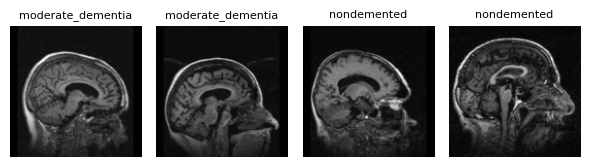

In [6]:
samples = 4

indices = [100, 300, 1100, 1500]

fig, axes = plt.subplots(1, 4, figsize=(6, 3))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    image, label = train_dataset[idx]
    ax.imshow(image.squeeze(0), cmap='gray')  # Remove channel dimension for display
    ax.set_title(f'{list(train_dataset.label_mapping.keys())[label]}', fontsize='8')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Define and create QNN
def create_qnn(n_qubits):
    
    feature_map = ZZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    estimator = Estimator()
    
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        estimator=estimator
    )
    return qnn, qc

qnn, qc = create_qnn(NUM_OF_QUBITS)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


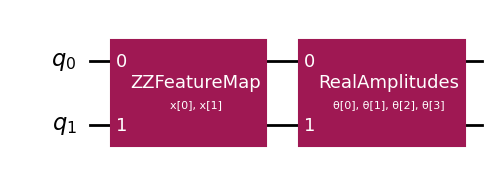

In [8]:
qc.draw(output="mpl")

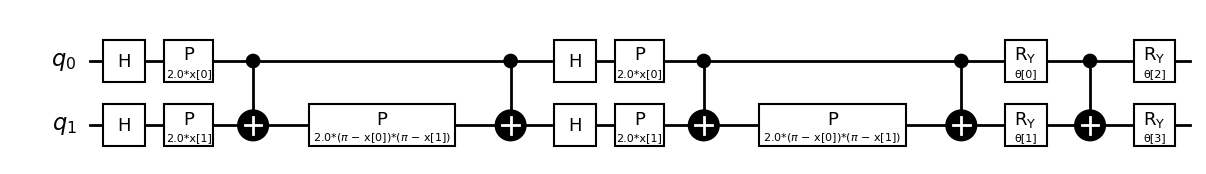

In [9]:
qc.decompose().draw(output="mpl", style="bw")

In [10]:
class Net(nn.Module):
    def __init__(self, qnn, image_size, n_qubits):
        super().__init__()
        self.image_size = image_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5)
        self.dropout = nn.Dropout2d()
        
        # Compute the size of the feature map after convolutions and pooling
        size_after_conv1 = (image_size - 5 + 1) // 2  # kernel=5, stride=1, pool=2
        size_after_conv2 = (size_after_conv1 - 5 + 1) // 2  # kernel=5, stride=1, pool=2
        
        # Calculate the flattened size for fc2
        self.flattened_size = 4 * size_after_conv2 * size_after_conv2
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 4)
        self.fc2 = nn.Linear(4, n_qubits)  
        self.qnn = TorchConnector(qnn)
        self.fc3 = nn.Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        x = cat((x, 1 - x), -1)
        return x

model = Net(qnn, IMAGE_SIZE, NUM_OF_QUBITS)

In [11]:
summary(model, (1, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 2, 124, 124]              52
            Conv2d-2            [-1, 4, 58, 58]             204
         Dropout2d-3            [-1, 4, 29, 29]               0
            Linear-4                    [-1, 4]          13,460
            Linear-5                    [-1, 2]              10
    TorchConnector-6                    [-1, 1]               4
            Linear-7                    [-1, 1]               2
Total params: 13,732
Trainable params: 13,732
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.36
Params size (MB): 0.05
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


In [12]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()  

In [13]:
# Callback classes/functions
class ReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.7, patience=3, min_lr=1e-6, verbose=1):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best_loss = float('inf')
        self.wait = 0

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                for param_group in self.optimizer.param_groups:
                    new_lr = max(param_group['lr'] * self.factor, self.min_lr)
                    param_group['lr'] = new_lr
                if self.verbose:
                    print(f"Reducing learning rate to {new_lr:.6f}")
                self.wait = 0

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def step(self, val_loss):
        if self.save_best_only:
            if (self.mode == 'min' and val_loss < self.best) or (self.mode == 'max' and val_loss > self.best):
                self.best = val_loss
                torch.save(model.state_dict(), self.filepath)

class CSVLogger:
    def __init__(self, filename):
        self.filename = filename
        with open(self.filename, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def log(self, epoch, train_loss, train_accuracy, val_loss, val_accuracy):
        with open(self.filename, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, train_accuracy, val_loss, val_accuracy])

In [14]:
# Instantiate callbacks
callbacks = [
    ReduceLROnPlateau(optimizer),
    ModelCheckpoint(filepath=os.path.abspath('../../../models/classification/2qubits/oasis-2_sagittal_2qubits.pt')),
    CSVLogger(os.path.abspath('../../../models/classification/2qubits/oasis-2_sagittal_2qubits.csv'))
]

In [15]:
# Training parameters
train_loss_list = []  # Store training loss history
train_accuracy_list = []  # Store training accuracy history
val_loss_list = []  # Store validation loss history
val_accuracy_list = []  # Store validation accuracy history
best_accuracy = 0  # Best accuracy tracker

# Print table header
print(f"{'Epoch':<10}{'Train Loss':<15}{'Train Accuracy':<20}{'Val Loss':<15}{'Val Accuracy':<20}")
print("="*72)

# Start training
start = timeit.default_timer()  # Total training start time

# Start training
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    
    total_loss = []
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        
        # Forward pass
        output = model(data)  # Use model for prediction
        loss = loss_func(output, target)  # Calculate loss
        
        # Backward pass
        loss.backward()
        optimizer.step()  # Optimize weights
        
        total_loss.append(loss.item())  # Store loss
        
        # Calculate training accuracy
        predicted = output.argmax(dim=1)  # Get predicted class
        correct_predictions += (predicted == target).sum().item()  # Count correct predictions
        total_samples += target.size(0)  # Count total samples
    
    # Calculate average training loss and accuracy
    avg_loss = sum(total_loss) / len(total_loss)
    training_accuracy = 100 * correct_predictions / total_samples
    train_loss_list.append(avg_loss)
    train_accuracy_list.append(training_accuracy)
    
    model.eval()  # Set model to evaluation mode
    
    accuracy = 0
    total_val_loss = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)  # Use model for validation
            
            # Calculate validation loss
            val_loss = loss_func(output, target)
            total_val_loss.append(val_loss.item())
            
            # Calculate validation accuracy
            predicted = output.argmax(dim=1)  # Get predicted class
            accuracy += (predicted == target).sum().item()  # Count correct predictions
        
        # Calculate average validation loss and accuracy
        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        val_accuracy = 100 * accuracy / len(test_loader.dataset)
        val_accuracy_list.append(val_accuracy)
        
        # Callbacks step
        for callback in callbacks:
            if isinstance(callback, ReduceLROnPlateau):
                callback.step(avg_val_loss)
            elif isinstance(callback, ModelCheckpoint):
                callback.step(avg_val_loss)
            elif isinstance(callback, CSVLogger):
                callback.log(epoch + 1, avg_loss, training_accuracy, avg_val_loss, val_accuracy)

    # Print training and validation metrics in a table format
    print(f"{epoch + 1:<10}{avg_loss:<15.4f}{training_accuracy:<20.2f}{avg_val_loss:<15.4f}{val_accuracy:<20.2f}")
        
stop = timeit.default_timer()  

Epoch     Train Loss     Train Accuracy      Val Loss       Val Accuracy        
1         0.6780         76.04               0.6429         99.58               
2         0.6353         92.08               0.6608         76.31               
3         0.5812         94.09               0.6281         82.81               
4         0.5216         96.16               0.5255         98.74               
5         0.4804         94.84               0.5588         91.82               


In [16]:
# Calculate total time in seconds
total_seconds = stop - start

# Convert seconds to hours, minutes, and seconds
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

# Print the formatted time
print(f"Total Training Time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Total Training Time: 0h 3m 57.16s


In [17]:
qnn, _ = create_qnn(NUM_OF_QUBITS)
model = Net(qnn, IMAGE_SIZE, NUM_OF_QUBITS)
model.load_state_dict(torch.load("../../../models/classification/2qubits/oasis-2_sagittal_2qubits.pt", weights_only=True))
model.eval()  # set model to evaluation mode

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3364, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [18]:
# Initialize lists to store true labels and predictions
y_true = []
y_pred = []
predictions = []

with torch.no_grad():
    total_loss = []
    correct = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        # Ensure output has the correct shape
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        # Apply softmax to get probabilities
        softmax_output = F.softmax(output, dim=1)  # Apply softmax along class dimension

        # Use softmax_output for probabilities
        predictions.extend(softmax_output.cpu().numpy())  # Collect probabilities (output after softmax)

        # Get the predicted class by taking the argmax of the softmax output
        pred = softmax_output.argmax(dim=1, keepdim=True)
        y_pred.extend(pred.cpu().numpy())  # Collect predictions (the class with the highest probability)
        y_true.extend(target.cpu().numpy())  # Collect true labels
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())

In [19]:
def to_categorical(y, num_classes):
    """ 1-hot encoding """
    return np.eye(num_classes, dtype='uint8')[y]

In [20]:
# y_true
y_true = to_categorical(y_true, 2)

# y_true_flat
y_true_flat = np.argmax(y_true, axis=-1)

In [21]:
# y_pred
y_pred = np.array(predictions)

# y_pred_flat
y_pred_flat = np.argmax(predictions, axis=-1)

In [22]:
############## ROC AUC ##############
neg_cls = 0 # nondemented
pos_cls = 1 # moderate_dementia

print("Positive Class AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true[:, pos_cls], y_pred[:, pos_cls])*100))
print("Negative Class AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true[:, neg_cls], y_pred[:, neg_cls])*100))
print("Average AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true, y_pred)*100))

Positive Class AUC:  100.00%
Negative Class AUC:  100.00%
Average AUC:  100.00%


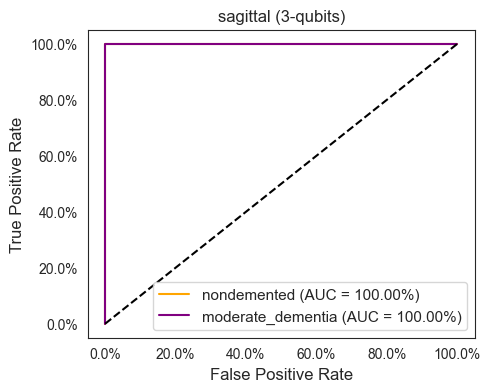

In [23]:
# Set Seaborn style
sns.set_style("white")

fig, ax = plt.subplots(figsize=(5, 4))

# Compute the ROC curve and AUC for each class
fpr_pos_cls, tpr_pos_cls, _ = roc_curve(y_true[:, pos_cls], y_pred[:, pos_cls])
auc_pos_cls = auc(fpr_pos_cls, tpr_pos_cls)

fpr_neg_cls, tpr_neg_cls, _ = roc_curve(y_true[:, neg_cls], y_pred[:, neg_cls])
auc_neg_cls = auc(fpr_neg_cls, tpr_neg_cls)

# Plot the ROC curves
ax.plot(fpr_pos_cls, tpr_pos_cls, color="orange", label=f"nondemented (AUC = {auc_pos_cls:.2%})")
ax.plot(fpr_neg_cls, tpr_neg_cls, color="purple", label=f"moderate_dementia (AUC = {auc_neg_cls:.2%})")

# Customize the ticks and labels on the axes
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

# Add the diagonal line, labels, title, and legend
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontsize='12')
plt.ylabel("True Positive Rate", fontsize='12')
plt.title("sagittal (3-qubits)", fontsize='12')
plt.legend(fontsize='11')
plt.show()

In [24]:
############## Classification Report ##############
targetnames = ['nondemented', 'moderate_dementia']

report = classification_report(y_true_flat, y_pred_flat, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
                   precision    recall  f1-score   support

      nondemented       1.00      0.99      0.99       424
moderate_dementia       0.91      1.00      0.95        53

         accuracy                           0.99       477
        macro avg       0.96      0.99      0.97       477
     weighted avg       0.99      0.99      0.99       477



In [25]:
TN, FP, FN, TP = confusion_matrix(y_true_flat, y_pred_flat).ravel()

sensitivity = '{0:.2f}'.format(TP/(TP+FN)*100)
specificity = '{0:.2f}'.format(TN/(TN+FP)*100)
    
precision = '{0:.2f}'.format(precision_score(y_true_flat, y_pred_flat)*100)
recall = '{0:.2f}'.format(recall_score(y_true_flat, y_pred_flat)*100)
f1 = '{0:.2f}'.format(f1_score(y_true_flat, y_pred_flat)*100)
accuracy = '{0:.2f}'.format(accuracy_score(y_true_flat, y_pred_flat)*100)

matrix_log = [[precision, recall, f1, accuracy, sensitivity, specificity, TN, FP, FN, TP]]
df_result = pd.DataFrame(
    matrix_log, 
    columns=[
        'Precision (%)',
        'Recall (%)', 
        'F1-Score (%)',
        'Accuracy (%)', 
        'Sensitivity (%)', 
        'Specificity (%)',
        'TN',
        'FP', 
        'FN', 
        'TP'
    ])

df_result = df_result.style.hide(axis='index')
df_result

Precision (%),Recall (%),F1-Score (%),Accuracy (%),Sensitivity (%),Specificity (%),TN,FP,FN,TP
91.38,100.00,95.50,98.95,100.00,98.82,419,5,0,53


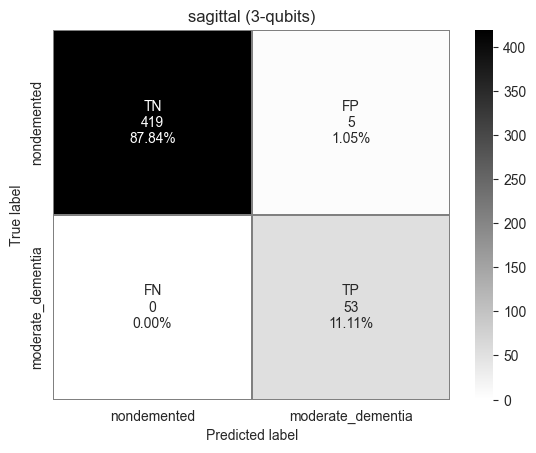

In [26]:
cnf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

matrix_labels = np.asarray(labels).reshape(2,2)
axis_labels = ['nondemented', 'moderate_dementia']

ax = sns.heatmap(
    cnf_matrix, 
    annot=matrix_labels, 
    fmt='',  
    cmap='binary', 
    linewidths=0.1, 
    linecolor='gray',
    xticklabels=axis_labels, 
    yticklabels=axis_labels
)

sns_figure = ax.set(xlabel='Predicted label', ylabel='True label', title='sagittal (3-qubits)')